In [1]:
from qibo import gates
import numpy as np
from qibo.models import Circuit
from tqdm.auto import tqdm
import os
from qibo.gates import X, RX, RY, RZ, CNOT, CZ, H, I
import utils.qst_qpt_functions as fun
import qibo
import qutip as qt
import qililab as ql
from itertools import product
import matplotlib.pyplot as plt

from qiboconnection.connection import ConnectionConfiguration
from qiboconnection.api import API

import qiboconnection


ql.logger.setLevel(50)

2023-11-14 12:19:15,642 - qm - INFO     - Starting session: 3d345b26-34e4-472a-8554-2f435ed9d397


In [5]:
qiboconnection.__version__

'0.14.4'

In [6]:
# # my user
# config = ConnectionConfiguration(username="vsanchez",api_key="ea712370-7516-4cbf-91a6-72a82e39ba02")
# connection = API(configuration=config)

In [7]:
# connection.select_device_ids(device_ids=[9])

#### Constants

In [2]:
QUBIT_A = 0
QUBIT_B = 1

NUM_SHOTS = 2000

#### Define sequence

In [3]:
def six_operators(qubit):
    return [
        I(qubit),
        X(qubit),
        RX(qubit, np.pi/2),
        RX(qubit, -np.pi/2), 
        RY(qubit, np.pi / 2),
        RY(qubit, -np.pi / 2)
    ]

# Circuits as they are in the function now should build the right phi states and switched psi states

In [4]:
def bell_state_tomography(qubit_a, qubit_b, select_bell):
    circuits = []

    for op1_a in six_operators(qubit_a):
        for op1_b in six_operators(qubit_b):
            circuit = Circuit(5)
            
            if select_bell == "phi_plus" or select_bell == "psi_minus": ## psi_plus has bit and phase flip, phi_plus only bit   A B
                G1 = RY(qubit_a, -np.pi/2)
            else:
                G1 = RY(qubit_a, np.pi/2)  
            if select_bell == "phi_plus" or select_bell == "phi_minus": ## phi_plus  and phi_minus have bit flip error      A  a
                G2_prime = RY(qubit_b, -np.pi/2)
            else:
                G2_prime = RY(qubit_b, np.pi/2) 
                
            ## build bell state
            circuit.add(G1) # parameters 0 and 1 , sets the sign/ phase of the bell state
            circuit.add(RY(qubit_b, np.pi/2))
            circuit.add(CZ(qubit_a, qubit_b))
            circuit.add(G2_prime) # parameters 4 and 5, sets the parity of the bell state
              
            ## state tomography part
            circuit.add(op1_a)  # RA
            circuit.add(op1_b)  # RB
            circuit.add(gates.M(qubit_a, qubit_b))

            circuits.append(circuit)

    # We add extra 4 gates to have a reference
    for gate_a in [gates.I, gates.X]:
        for gate_b in [gates.I, gates.X]:
            circuit = Circuit(5)
            circuit.add(gate_a(qubit_a))
            circuit.add(gate_b(qubit_b))
            circuit.add(gates.M(qubit_a, qubit_b))

            circuits.append(circuit)

    return circuits

In [5]:
qubit_a = 0
qubit_b = 1

# for select_bell in ['phi_plus', 'phi_minus', 'psi_plus', 'psi_minus']:
for select_bell in ['phi_plus']:

    circuit = Circuit(2)

    if select_bell in ["phi_plus", "psi_minus"]: ## psi_plus has bit and phase flip, phi_plus only bit   A B
        G1 = RY(qubit_a, -np.pi/2)
    else:
        G1 = RY(qubit_a, np.pi/2)
    if select_bell in ["phi_plus", "phi_minus"]: ## phi_plus  and phi_minus have bit flip error      A  a
        G2_prime = RY(qubit_b, -np.pi/2)
    else:
        G2_prime = RY(qubit_b, np.pi/2) 

    ## build bell state
    circuit.add(G1) # parameters 0 and 1 , sets the sign/ phase of the bell state
    circuit.add(RY(qubit_b, np.pi/2))
    circuit.add(CZ(qubit_a, qubit_b))
    circuit.add(G2_prime) # parameters 4 and 5, sets the parity of the bell state


    print(select_bell, np.round(circuit().state(), 3))
    print("\n", np.round(np.kron(circuit().state(), circuit().state().T).reshape(4,4),3))
    print(circuit.draw())

phi_plus [ 0.707+0.j  0.   +0.j -0.   +0.j  0.707+0.j]

 [[ 0.5+0.j  0. +0.j -0. +0.j  0.5+0.j]
 [ 0. +0.j  0. +0.j -0. +0.j  0. +0.j]
 [-0. +0.j -0. +0.j  0. -0.j -0. +0.j]
 [ 0.5+0.j  0. +0.j -0. +0.j  0.5+0.j]]
q0: ─RY─o────
q1: ─RY─Z─RY─


#### Run sequences

In [12]:
bell_flags = ['phi_plus', 'phi_minus', 'psi_plus', 'psi_minus']
# bell_flags = ['phi_plus']
bell_results_ids = {}
for i, bell_flag in enumerate(bell_flags):
    circuits = bell_state_tomography(QUBIT_A, QUBIT_B, select_bell=bell_flag)
    job_id = connection.execute(circuit=circuits, nshots=4000)
    bell_results_ids[bell_flag] = job_id


In [16]:
a = bell_state_tomography(QUBIT_A, QUBIT_B, select_bell="psi_minus")[0](nshots=2000).frequencies()

In [20]:
a

Counter({'10': 53, '01': 47, '00': 0, '11': 0})

In [19]:
dict(a)
for basis in ("00", "01", "10", "11"):
    if basis not in a:
        a[basis] = 0

In [24]:
def get_measurement_calibration_weights(dataMMT, nsubsets=1):
    data_combined_bitstrings = fun.get_binbitstrings_from_loadresults(dataMMT)
    means_bitstrings, _ = fun.get_probabilities_data_combined_bitstrings(data_combined_bitstrings, nsubsets=nsubsets)
    _, stds_measops = fun.get_probabilities_data_combined_measurementops(data_combined_bitstrings, nsubsets=nsubsets)
    coeffs_mat, ideal_measurements = fun.prepare_linear_system_measurement_calibration(processed_data=means_bitstrings)

    if nsubsets == 1:
        stds_measops = None ### FIXME:  Tell the function to take it as None as well when it's an array full of zeros
    initial_guess = None
    
    return fun.solve_linear_system_measurement_calibration(
        coeff_matrix=coeffs_mat,
        independent_term=ideal_measurements,
        wlsq_stds=stds_measops,
        initial_guess=initial_guess,
    )

In [37]:
def mock_results_with_qibo(bell_flag):
    results = [dict(result(nshots=2000).frequencies()) for result in bell_state_tomography(QUBIT_A, QUBIT_B, select_bell=bell_flag)]
    
    temp_results = []
    for result in results:
        for basis in ("00", "01", "10", "11"):
            if basis not in result:
                result[basis] = 0
        temp_results.append({"probabilities":result})
    return temp_results


In [38]:
bell_flags = ['phi_plus', 'phi_minus', 'psi_plus', 'psi_minus'] # QIBO
bell_results = {}
for bell_flag in bell_flags:
    # bell_results[bell_flag] = connection.get_result(job_id=bell_results_ids[bell_flag][0])
    bell_results[bell_flag] = mock_results_with_qibo(bell_flag) # QIBO
[value for value in bell_results.values()][-1]

[{'probabilities': {'01': 979, '10': 1021, '00': 0, '11': 0}},
 {'probabilities': {'00': 1037, '11': 963, '01': 0, '10': 0}},
 {'probabilities': {'00': 505, '01': 499, '10': 489, '11': 507}},
 {'probabilities': {'00': 506, '01': 511, '10': 492, '11': 491}},
 {'probabilities': {'00': 491, '01': 519, '10': 495, '11': 495}},
 {'probabilities': {'00': 524, '01': 500, '10': 484, '11': 492}},
 {'probabilities': {'00': 990, '11': 1010, '01': 0, '10': 0}},
 {'probabilities': {'01': 991, '10': 1009, '00': 0, '11': 0}},
 {'probabilities': {'00': 492, '01': 496, '10': 485, '11': 527}},
 {'probabilities': {'00': 500, '01': 540, '10': 475, '11': 485}},
 {'probabilities': {'00': 511, '01': 518, '10': 468, '11': 503}},
 {'probabilities': {'00': 518, '01': 475, '10': 526, '11': 481}},
 {'probabilities': {'00': 490, '01': 510, '10': 496, '11': 504}},
 {'probabilities': {'00': 500, '01': 514, '10': 481, '11': 505}},
 {'probabilities': {'01': 954, '10': 1046, '00': 0, '11': 0}},
 {'probabilities': {'00':

In [39]:
bell_results["phi_plus"]

[{'probabilities': {'00': 1008, '11': 992, '01': 0, '10': 0}},
 {'probabilities': {'01': 968, '10': 1032, '00': 0, '11': 0}},
 {'probabilities': {'00': 523, '01': 501, '10': 503, '11': 473}},
 {'probabilities': {'00': 473, '01': 512, '10': 538, '11': 477}},
 {'probabilities': {'00': 496, '01': 502, '10': 515, '11': 487}},
 {'probabilities': {'00': 467, '01': 486, '10': 515, '11': 532}},
 {'probabilities': {'01': 1000, '10': 1000, '00': 0, '11': 0}},
 {'probabilities': {'00': 959, '11': 1041, '01': 0, '10': 0}},
 {'probabilities': {'00': 523, '01': 493, '10': 471, '11': 513}},
 {'probabilities': {'00': 512, '01': 502, '10': 515, '11': 471}},
 {'probabilities': {'00': 477, '01': 498, '10': 519, '11': 506}},
 {'probabilities': {'00': 476, '01': 515, '10': 505, '11': 504}},
 {'probabilities': {'00': 525, '01': 499, '10': 507, '11': 469}},
 {'probabilities': {'00': 489, '01': 501, '10': 521, '11': 489}},
 {'probabilities': {'01': 977, '10': 1023, '00': 0, '11': 0}},
 {'probabilities': {'00'

In [40]:
def get_probstrings_from_qiboconresults(mmt_data: list[dict]):
    """
    Get probability data from qiboconnection results

    Args:
        mmt_data [list(dict)]: list of dictionary, each object is a dictionary with shape e.g.
        {'probabilities': {'00': 0.31275, '01': 0.29825, '10': 0.16675, '11': 0.22225}}
    """
    ncircuits = len(mmt_data)
    data_combined_bitstrings = np.zeros((ncircuits, 4))
    for k_c, data in enumerate(mmt_data):
            data_combined_bitstrings[k_c, 0] =  data["probabilities"]["00"] # "00"
            data_combined_bitstrings[k_c, 1] = data["probabilities"]["01"] # "01"
            data_combined_bitstrings[k_c, 2] = data["probabilities"]["10"] # "10"
            data_combined_bitstrings[k_c, 3] = data["probabilities"]["11"] # "11"
    return data_combined_bitstrings

In [41]:
def get_measurement_calibration_weights(dataMMT, nsubsets=1):
    means_bitstrings = get_probstrings_from_qiboconresults(dataMMT)
    coeffs_mat, ideal_measurements = fun.prepare_linear_system_measurement_calibration(processed_data=means_bitstrings)

    if nsubsets == 1:
        stds_measops = None ### FIXME:  Tell the function to take it as None as well when it's an array full of zeros
    initial_guess = None
    
    return fun.solve_linear_system_measurement_calibration(
        coeff_matrix=coeffs_mat,
        independent_term=ideal_measurements,
        wlsq_stds=stds_measops,
        initial_guess=initial_guess,
    )

In [42]:
def prepare_linear_system_QST(
    measurement_calibration_weights, means_ops_Rcircuit, stds_ops_Rcircuit
):
    """
    Returns all the components of the linear system to be solved to perform process tomography.
    """
    weights_state_tomography = (
        fun.get_weights_state_tomography()
    )  # has indices i, n, k, i.e., shape (3, 16, len(combs))
    beta_Mi_calibration_matrix = measurement_calibration_weights  # this should have dim (4, 3), i.e., each column
    # is a measurement operator and each row
    # the coefficient accompanying II, IZ, ZI, ZZ
    # in that order
    len_combs = 36
    coeff_matrix = np.zeros((3 * len_combs, 15))  # we only need to solve 15 variables because of normalisation (p0 = 1-\sum_{n=1} pn)
    independent_term = np.zeros(3 * len_combs)  # will be filled by self.post_processed_results
    wlsq_stds = np.zeros(3 * len_combs)

    #### means_ops_Rcircuit has shape (36, 3)
    stds_ops_Rcircuit = stds_ops_Rcircuit.reshape(36, 3) if stds_ops_Rcircuit is not None else np.zeros((36, 3))  ## so that the loop below doesn't complain
        ## we flatten it automatically when we return it in
        ## get_probabilities_data_combined_measurementops() because of convenience for the measurement
        ### calibration experiment, but for qst it's convenient to keep it separated to ensure we are not mirring the order.
        #### TODO: check whether the resulting order is indeed different from having it flattened in the first place
        # (it seems so)

    for alpha, (i, k) in enumerate(product(range(3), range(len_combs))):  # alpha from 0 to 107; i from 0 to 2; k from 0 to 35
        for n in range(15):
            coeff_matrix[alpha, n] += np.sum(
                beta_Mi_calibration_matrix[1:, i]
                * weights_state_tomography[:, n + 1, k]
            )
        # the n+1 is because the weight matrix had the identity there
        dat_means_ops = means_ops_Rcircuit[k]
        dat_stds_ops = stds_ops_Rcircuit[k]

        independent_term[alpha] = (
            dat_means_ops[i] - beta_Mi_calibration_matrix[0, i] / 4
        )
        wlsq_stds[alpha] = dat_stds_ops[i]

    if stds_ops_Rcircuit is None:
        wlsq_stds = None

    return coeff_matrix, independent_term, wlsq_stds

In [43]:
bell_strings = ['$|00 \\rangle + |11 \\rangle$', '$|00 \\rangle - |11 \\rangle$', '$|01 \\rangle + |10 \\rangle$', '$|01 \\rangle - |10 \\rangle$']

nsubsets = 1 ## loop below hardcoded for a single subset, but in all the previous data sets there's little to no difference for tiny statistics at least

state_reconstruction_paulibasis = np.zeros((4, 16))

for bell_ind, bell_flag in enumerate(bell_flags):
    mmt_data = bell_results[bell_flag]
    dataQST, dataMMT = mmt_data[:36], mmt_data[36:]
    
    measurement_calibration_weights = get_measurement_calibration_weights(dataMMT, nsubsets=nsubsets)
    
    means_measops = get_probstrings_from_qiboconresults(dataQST)

    measurement_calibration_weights = np.linalg.pinv(measurement_calibration_weights)
    
    coeff_matrix, independent_term, wlsq_stds = prepare_linear_system_QST(measurement_calibration_weights, means_measops, None)

    reconstructed_vector_noII = fun.solve_linear_system_QST(coeff_matrix=coeff_matrix, 
                                                        independent_term=independent_term, 
                                                        wlsq_stds=None,
                                                        initial_guess=np.zeros(15))

    state_reconstruction_paulibasis[bell_ind] = np.append(1/4, reconstructed_vector_noII)
            # P_index += 1

In [44]:
for bell_ind, bell_flag in enumerate(bell_flags):
    
    v = state_reconstruction_paulibasis[bell_ind]
    rh = fun.take_pauli_reconstructed_state_to_density_matrix(v)
    rh_qt = qt.Qobj(rh, dims=[[2]*2]*2)
    print(bell_flag, qt.entropy_vn(rh_qt.ptrace(0), base=2))

phi_plus 0.9999884584088952
phi_minus 0.9999884584088952
psi_plus 0.9999884584088952
psi_minus 0.9999884584088952


In [1]:

fig=plt.figure(figsize=(10,10))
for bell_id, bell_flag in enumerate(bell_flags):

    v = state_reconstruction_paulibasis[bell_id]
    rh = fun.take_pauli_reconstructed_state_to_density_matrix(v)
    print(qt.Qobj(rh))
    ax = fig.add_subplot(2, 2, bell_id+1, projection='3d')
    ax.set_title(bell_flag)
    fun.plot_matrix(rh, ax=ax)

NameError: name 'plt' is not defined

## Plot 36 states in the Pauli basis

Collection of indices of observables corresponding to first and second qubits and their correlations

In [46]:
one_local = ['IX', 'IY', 'IZ', 'XI', 'YI', 'ZI']
two_local = [''.join(x) for x in product(['X', 'Y', 'Z'], repeat=2)]
original_order = [''.join(x) for x in product(['I', 'X', 'Y', 'Z'], repeat=2)]
final_xticklabels = one_local
final_xticklabels.extend(two_local)

index_reordering = [original_order.index(x) for x in final_xticklabels]

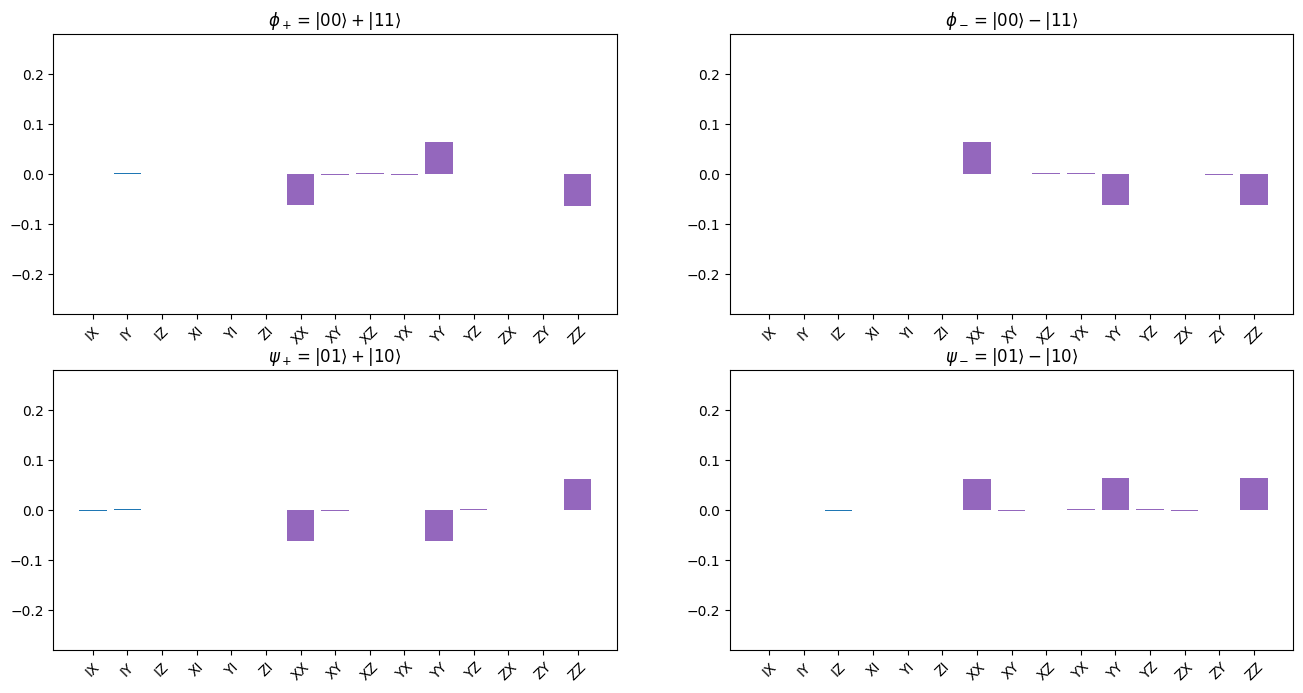

In [47]:
bell_strings = ['$|00 \\rangle + |11 \\rangle$', '$|00 \\rangle - |11 \\rangle$', '$|01 \\rangle + |10 \\rangle$', '$|01 \\rangle - |10 \\rangle$']
fig, axes = plt.subplots(2,2, figsize = (16, 8))


for bell_ind, bell_flag in enumerate(bell_flags):
    bellflag_split = bell_flag.split('_')
    if bellflag_split[1]=='plus':
        sg = '+'
    elif bellflag_split[1]=='minus':
        sg = '-'

    jj = bell_ind % 2
    ii = bell_ind//2

    xtickslbls = [''.join(x) for x in product(['I', 'X', 'Y', 'Z'], repeat=2)]
    xtickslbls = xtickslbls[1:]

    basicrots = ['$I$', '$X_\\pi$', '$X_{\\pi/2}$', '$X_{-\\pi/2}$', '$Y_{\\pi/2}$', '$Y_{-\\pi/2}$']
    # titles = list(' '.join(x) for x in product(basicrots, repeat=2))
    titles = [''.join((x[1], x[0])) for x in product(basicrots, repeat=2)]
    indices_secondqb = [4, 8, 12]
    correlation_indices = list(range(3, 15))
    for x in indices_secondqb:
        correlation_indices.remove(x)

    ax = axes[ii, jj]
    ax.bar(range(3), state_reconstruction_paulibasis[bell_ind, 1:4], color='C0')
    ax.bar(range(3, 6), state_reconstruction_paulibasis[bell_ind, index_reordering[3:6]], color='C3')
    ax.bar(range(6, 15), state_reconstruction_paulibasis[bell_ind, index_reordering[6:]], color='C4')
    ax.set_xticks(range(15))
    ax.set_ylim(-0.28, 0.28)
    ax.set_xticklabels(final_xticklabels, rotation=45)
    ax.set_title(f'$\\{bellflag_split[0]}_{sg} = ${bell_strings[bell_ind]}')
        
    # fig.savefig('qst36states_20231004_qbs2_4_nshots1000_dataset0.png')